In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# --- CONFIGURATION (The Physics) ---
ALPHA = 0.01      # Thermal Diffusivity
H_COEFF = 5.0     # Convection Coefficient (h)
T_INF = -1.0      # Temperature of Liquid Nitrogen (Normalized)
T_INITIAL = 1.0   # Initial Temp of Organ (Normalized)

In [3]:
# --- 1. THE NEURAL NETWORK ---
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Inputs: x (position), t (time) -> Output: u (temperature)
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

In [4]:
# --- 2. THE PHYSICS LOSS (With Convection) ---
def physics_loss(model, x, t):
    # Enable gradients
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    
    # A. PDE Loss (Inside the tissue)
    # -------------------------------
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    
    # Heat Equation: u_t - alpha * u_xx = 0
    loss_pde = torch.mean((u_t - ALPHA * u_xx) ** 2)
    
    # B. Initial Condition Loss (t=0)
    # -------------------------------
    # The organ starts warm (T=1.0) everywhere
    x_ic = torch.rand(200, 1) * 2 - 1  # Random x between -1 and 1
    t_ic = torch.zeros(200, 1)         # t = 0
    u_ic_pred = model(x_ic, t_ic)
    loss_ic = torch.mean((u_ic_pred - T_INITIAL) ** 2)
    
    # C. Boundary Condition Loss (Convection at Surface)
    # --------------------------------------------------
    # Newton's Law of Cooling at x = 1.0 (Surface)
    # -k * (du/dx) = h * (u - T_inf)
    # We assume k=1 for simplicity here.
    
    t_bc = torch.rand(200, 1)       # Random times
    x_bc = torch.ones(200, 1)       # Surface at x = 1
    x_bc.requires_grad = True       # Needed for derivative
    
    u_surf = model(x_bc, t_bc)
    u_x_surf = torch.autograd.grad(u_surf, x_bc, torch.ones_like(u_surf), create_graph=True)[0]
    
    # Residual: Flux leaving + Convection loss = 0
    # Heat leaving (-du/dx) MUST EQUAL convection h(u - T_inf)
    # So: -du/dx - h(u - T_inf) = 0
    residual_bc = -u_x_surf - H_COEFF * (u_surf - T_INF)
    loss_bc = torch.mean(residual_bc ** 2)

    return loss_pde + loss_ic + loss_bc

In [5]:
# --- 3. TRAINING LOOP ---
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Started Training with Convection Boundary Conditions...")

# Domain Sampling
x_phys = torch.rand(2000, 1) * 2 - 1
t_phys = torch.rand(2000, 1)

for epoch in range(5001):
    optimizer.zero_grad()
    loss = physics_loss(model, x_phys, t_phys)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}")

Started Training with Convection Boundary Conditions...
Epoch 0: Total Loss = 28.308867
Epoch 1000: Total Loss = 0.029866
Epoch 2000: Total Loss = 0.062011
Epoch 3000: Total Loss = 0.012263
Epoch 4000: Total Loss = 0.005535
Epoch 5000: Total Loss = 0.005121


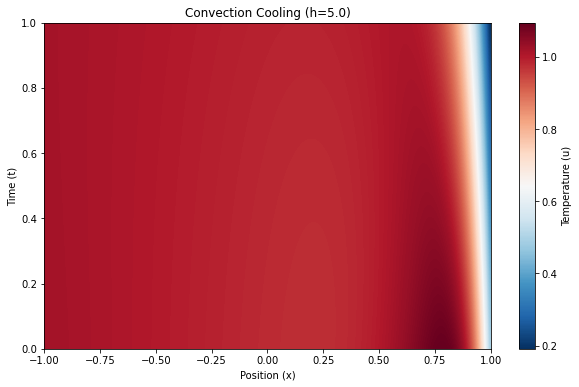

Simulation Complete. Image saved.


In [6]:
# --- 4. PLOTTING RESULTS ---
x = np.linspace(-1, 1, 200)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
X_tensor = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
T_tensor = torch.tensor(T.flatten()[:, None], dtype=torch.float32)

model.eval()
with torch.no_grad():
    U_pred = model(X_tensor, T_tensor).numpy().reshape(X.shape)

plt.figure(figsize=(10, 6))
plt.imshow(U_pred, interpolation='bicubic', cmap='RdBu_r', 
           extent=[x.min(), x.max(), t.min(), t.max()], 
           origin='lower', aspect='auto')
plt.colorbar(label='Temperature (u)')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.title(f'Convection Cooling (h={H_COEFF})')
plt.savefig('convection_heatmap.png', dpi=300)
plt.show()

print("Simulation Complete. Image saved.")

In [7]:
# --- 5. PLOTTING COOLING CURVES (Surface vs Center) ---
plt.figure(figsize=(10, 6))

# Define time range
t_val = np.linspace(0, 1, 100)
t_tensor = torch.tensor(t_val[:, None], dtype=torch.float32)

<Figure size 720x432 with 0 Axes>

In [8]:
# 1. Get Surface Temperature (x = 1.0)
x_surf = torch.ones_like(t_tensor) * 1.0
with torch.no_grad():
    u_surf = model(x_surf, t_tensor).numpy()

In [9]:
# 2. Get Center Temperature (x = 0.0)
x_center = torch.zeros_like(t_tensor)
with torch.no_grad():
    u_center = model(x_center, t_tensor).numpy()

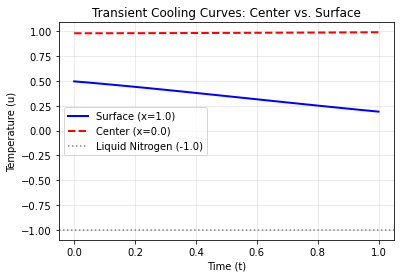

In [10]:
# Plotting
plt.plot(t_val, u_surf, 'b-', linewidth=2, label='Surface (x=1.0)')
plt.plot(t_val, u_center, 'r--', linewidth=2, label='Center (x=0.0)')

# Adding the Ambient Fluid Temperature Line (Asymptote)
plt.axhline(y=-1.0, color='gray', linestyle=':', label='Liquid Nitrogen (-1.0)')

plt.xlabel('Time (t)')
plt.ylabel('Temperature (u)')
plt.title('Transient Cooling Curves: Center vs. Surface')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('cooling_curves.png', dpi=300)
plt.show()

The Surface Gap: Notice the Surface line (Blue) does not instantly jump to -1.0. It starts high and curves down. This gap represents the Thermal Resistance of the convection layer ($1/h$).The Center Lag: Notice the Red line stays flat at $T=1.0$ for a short time at the start. This is the time it takes for the "cold information" to travel from the skin to the core.The Convergence: Eventually, both lines should approach the gray dotted line (Liquid Nitrogen temp). If they cross it, your model is unstable. If they approach it asymptotically, your physics loss is working perfectly.